Initial notebook for the Unitary Fund's QRISE 2024 challenge 


Unitary Fund mitiq GitHub
https://github.com/unitaryfund/mitiq?tab=readme-ov-file

Qiskit Documentation
https://docs.quantum.ibm.com/

Cirq Documentation
https://quantumai.google/cirq/start/basics

mitiq Documentation
https://github.com/natestemen/talks/blob/main/2024-03-13-qrise/demo.ipynb



TODO: Compare PEC, maybe try for Ansatz?



Basic ZNE using Cirq


In [2]:
import mitiq
from mitiq.zne.inference import RichardsonFactory, LinearFactory, ExpFactory
import cirq
import warnings

warnings.filterwarnings('ignore')
frontend="cirq"

def execute(circuit, noise_level=0.005):
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit
    with depolarizing noise."""

    # add depolarizing noise
    noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))

    return (
        cirq.DensityMatrixSimulator()
        .simulate(noisy_circuit)
        .final_density_matrix[0, 0]
        .real
    )

def execute_no_noise(circuit):
    return (
        cirq.DensityMatrixSimulator()
        .simulate(circuit)
        .final_density_matrix[0, 0]
        .real
    )

a, b, c = cirq.LineQubit.range(3)

circuit = cirq.Circuit(
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.CNOT(b, c),
    cirq.S(a),
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.CNOT(b, c),
    cirq.S(a),
)

factory = LinearFactory([1, 4, 7])
factory.run(circuit, execute_no_noise)
control = factory.reduce()

factory = RichardsonFactory([1, 4, 7])
factory.run(circuit, execute)
first = factory.reduce()

factory = LinearFactory([1, 4, 7])
factory.run(circuit, execute)
second = factory.reduce()

factory = ExpFactory([1, 4, 7])
factory.run(circuit, execute)
third = factory.reduce()

triple_zne = (first + second + third) / 3

print(f"control: {control}")
print(f"first: {first}")
print(f"second: {second}")
print(f"third: {third}")
print(f"avg: {triple_zne}")
print(f"error 1 = {abs(control - first)} error 2 = {abs(control - second)} error 3 = {abs(control - third)} error tzne = {abs(control - triple_zne)}")

control: 0.24999997019767756
first: 0.25158831642733687
second: 0.2457558164993921
third: 0.25335582806023266
avg: 0.2502333203289872
error 1 = 0.0015883462296593098 error 2 = 0.004244153698285458 error 3 = 0.0033558578625551005 error tzne = 0.00023335013130965088


Let's try running this multiple times and graph our results.  While Triple ZNE seems to net better results, the repeatability seems somewhat unpredictable.

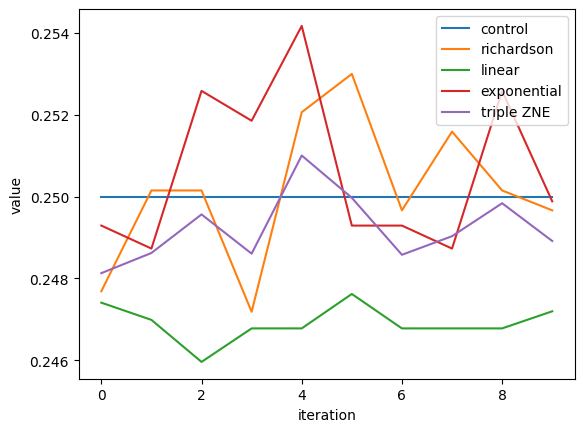

In [13]:
import matplotlib.pyplot as plt
import mitiq
from mitiq.zne.inference import RichardsonFactory, LinearFactory, ExpFactory
import cirq
import warnings

warnings.filterwarnings('ignore')
frontend="cirq"


x = []
control_y = []
richardson_y = []
linear_y = []
exp_y = []
t_zne_y = []

for i in range(0, 10):
    try:
        factory = LinearFactory([1, 4, 7])
        factory.run(circuit, execute_no_noise)
        control = factory.reduce()
        control_y.append(control)

        f2 = RichardsonFactory([1, 4, 7])
        f2.run(circuit, execute)
        first = f2.reduce()
        richardson_y.append(first)

        f3 = LinearFactory([1, 4, 7])
        f3.run(circuit, execute)
        second = f3.reduce()
        linear_y.append(second)

        f4 = ExpFactory([1, 4, 7])
        f4.run(circuit, execute)
        third = f4.reduce()
        exp_y.append(third)

        triple_zne = (first + second + third) / 3
        t_zne_y.append(triple_zne)

        x.append(i)
    except:
        continue


plt.plot(x, control_y, label="control")
plt.plot(x, richardson_y, label='richardson')
plt.plot(x, linear_y, label='linear')
plt.plot(x, exp_y, label='exponential')
plt.plot(x, t_zne_y, label='triple ZNE')
plt.xlabel("iteration")
plt.ylabel("value")
plt.legend()
plt.show()


What if we made a function to let a user choose whether to use Richardson, Linear, or Exp (can be expanded to include others) three times instead of using three different fit methods?

In [28]:
import mitiq
from mitiq.zne.inference import RichardsonFactory, LinearFactory, ExpFactory
import cirq
frontend="cirq"


def execute_no_noise(circuit):
    return (
        cirq.DensityMatrixSimulator()
        .simulate(circuit)
        .final_density_matrix[0, 0]
        .real
    )

a, b, c = cirq.LineQubit.range(3)

circuit = cirq.Circuit(
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.CNOT(b, c),
    cirq.S(a),
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.CNOT(b, c),
    cirq.S(a),
)

def execute(circuit, noise_level=0.005):
    noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))

    return (
        cirq.DensityMatrixSimulator()
        .simulate(noisy_circuit)
        .final_density_matrix[0, 0]
        .real
    )


factory = LinearFactory([1, 4, 7])
factory.run(circuit, execute_no_noise)
control = factory.reduce()

factory = LinearFactory([1, 4, 7])
factory.run(circuit, execute)
first = factory.reduce()

factory = LinearFactory([1, 4, 7])
factory.run(circuit, execute)
second = factory.reduce()

factory = LinearFactory([1, 4, 7])
factory.run(circuit, execute)
third = factory.reduce()

triple_zne = (first + second + third) / 3

print(f"control: {control}")
print(f"first: {first}")
print(f"second: {second}")
print(f"third: {third}")
print(f"avg: {triple_zne}")
print(f"error 1 = {abs(control - first)} error 2 = {abs(control - second)}" \
       f"error 3 = {abs(control - third)} error tzne = {abs(control - triple_zne)}")

control: 0.24999997019767756
first: 0.24677684406439465
second: 0.2463643799225489
third: 0.24740614990393328
avg: 0.24684912463029227
error 1 = 0.0032231261332829053 error 2 = 0.003635590275128664error 3 = 0.0025938202937442756 error tzne = 0.003150845567385291


Instead of using all 3, what if we write a function to let a user choose which fitting method is used?  Additionally, what if we just repeat one fit method three times and average it out instead of using 3 different fit methods?

In [11]:
import mitiq
from mitiq.zne.inference import RichardsonFactory, LinearFactory, ExpFactory
import cirq

frontend="cirq"

a, b, c = cirq.LineQubit.range(3)

circuit = cirq.Circuit(
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.CNOT(b, c),
    cirq.S(a),
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.CNOT(b, c),
    cirq.S(a),
)

def execute_no_noise(circuit):
    return (
        cirq.DensityMatrixSimulator()
        .simulate(circuit)
        .final_density_matrix[0, 0]
        .real
    )

def execute(circuit, noise_level=0.005):
    noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))

    return (
        cirq.DensityMatrixSimulator()
        .simulate(noisy_circuit)
        .final_density_matrix[0, 0]
        .real
    )

def zne(circuit):
    factory = LinearFactory([1, 4, 7])
    factory.run(circuit, execute_no_noise)
    return factory.reduce()

def execute_t_zne(circuit, factory_type):
    sum = 0
    match(factory_type):
        case 'l':
            for i in range(0, 3):
                factory = LinearFactory([1, 4, 7])
                factory.run(circuit, execute)
                sum += factory.reduce()
                #print(sum)
            return sum / 3
        case 'e':
            for i in range(0, 3):
                factory = ExpFactory([1, 4, 7])
                factory.run(circuit, execute)
                sum += factory.reduce()
                #print(sum)
            return sum / 3
        case 'r':
            for i in range(0, 3):
                factory = RichardsonFactory([1, 4, 7])
                factory.run(circuit, execute)
                sum += factory.reduce()
                #print(sum)
            return sum / 3

zne_factory_type = input("Please enter a fitting method (l, e, r)")
control_no_noise = execute_no_noise(circuit)
control_noise = execute(circuit)
zne_single = zne(circuit)
t_zne = execute_t_zne(circuit, zne_factory_type)
print(f"ideal circuit: {control_no_noise}")
print(f'normal noise: {control_noise}')
print(f'single zne: {zne_single}')
print(f'triple zne: {t_zne}')
print(f'error w/o mitigation: {abs(control_no_noise - control_noise)}')
print(f'error with single zne: {abs(control_no_noise - zne_single)}')
print(f'error with t_zne: {abs(control_no_noise - t_zne)}')

ideal circuit: 0.2499999701976776
normal noise: 0.24113260209560394
single zne: 0.24999997019767756
triple zne: 0.24692044655481973
error w/o mitigation: 0.00886736810207367
error with single zne: 5.551115123125783e-17
error with t_zne: 0.0030795236428578787


Graph Results

We chose to make a line graph to show how closely repeating ZNE 3 times and averaging out the resulting value fit with the ideal value.

Unfortunately, even if there was a slight increase in cell 6, it seems relatively random, and cell 7 seems to show that it's better to just use ZNE once.  Perhaps this is because more executions means more chances to have errors from noise?

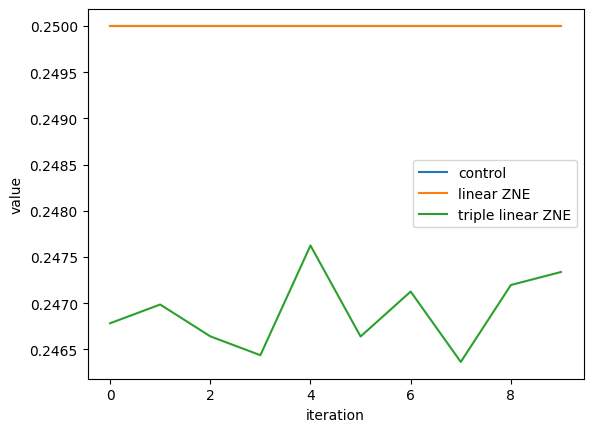

In [12]:
import mitiq
from mitiq.zne.inference import RichardsonFactory, LinearFactory, ExpFactory
import cirq
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
frontend="cirq"

x = []
control_y = []
zne_y = []
t_zne_y = []

for i in range(0, 10):
    x.append(i)
    control_y.append(float(execute_no_noise(circuit)))
    zne_y.append(zne(circuit))
    t_zne_y.append(float(execute_t_zne(circuit, factory_type='l')))

plt.plot(x, control_y, label="control")
plt.plot(x, zne_y, label='linear ZNE')
plt.plot(x, t_zne_y, label='triple linear ZNE')
plt.xlabel("iteration")
plt.ylabel("value")
plt.legend()
plt.show()

DDD with mitiq from demo 

In [6]:
from mitiq.benchmarks import generate_ghz_circuit
from mitiq import ddd


num_qubits = 6
ghz = generate_ghz_circuit(num_qubits)

#print(ghz)
ddd.insert_ddd_sequences(ghz, rule=ddd.rules.xx)
ddd.execute_with_ddd(ghz, execute, rule=ddd.rules.xx)

0.4451800286769867

What about DDD plus ZNE?  What if we triple this up?

After testing, attempting to triple ZNE up using the decorators doesn't seem to impart improvement.  Additionally, it would seem that similar to Triple ZNE, more tests (or averaging) means more noise and therefore less accurate results.

In [11]:
from mitiq import zne, ddd
from mitiq.zne.scaling import fold_global, fold_gates_at_random, insert_id_layers
from mitiq.zne.inference import RichardsonFactory


# Circuit
a, b, c = cirq.LineQubit.range(3)
cir = cirq.Circuit(
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.CNOT(b, c),
    cirq.S(a),
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.CNOT(b, c),
    cirq.S(a),
)

# Control
control = execute_no_noise(cir)
print(f"control: {control}")

# Demo example
@ddd.ddd_decorator(rule=ddd.rules.xyxy)
@zne.zne_decorator(factory=RichardsonFactory([1, 3, 7]), scale_noise=insert_id_layers)
def new_execute(circuit):
    return execute(circuit)

ddd_zne = new_execute(cir)
print(f"ddd + zne value: {ddd_zne}")
print(f"ddd+zne error: {abs(control - ddd_zne)}")

# Takes longer
@ddd.ddd_decorator(rule=ddd.rules.xyxy)
@zne.zne_decorator(factory=RichardsonFactory([1, 3, 7]), scale_noise=insert_id_layers)
@zne.zne_decorator(factory=RichardsonFactory([1, 3, 7]), scale_noise=insert_id_layers)
@zne.zne_decorator(factory=RichardsonFactory([1, 3, 7]), scale_noise=insert_id_layers)
def new_execute(circuit):
    return execute(circuit)

ddd_3zne = new_execute(cir)
print(f'ddd + 3zne: {ddd_3zne}')
print(f'ddd + 3zne error: {abs(control - ddd_3zne)}')

control: 0.2499999701976776
ddd + zne value: 0.2498570270836352
ddd+zne error: 0.00014294311404242088
ddd + 3zne: 0.24496387223189217
ddd + 3zne error: 0.005036097965785441


What if we tried to combine PEC with DDD?  How does it stack up to just PEC or DDD?

In [24]:
import cirq
from mitiq import ddd
import time

a, b, c = cirq.LineQubit.range(3)

circuit = cirq.Circuit(
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.CNOT(b, c),
    cirq.S(a),
    
)


ideal = execute_no_noise(circuit)
noisy_value = execute(circuit)

"""
Only DDD
"""
time_start = time.time()

@ddd.ddd_decorator(rule=ddd.rules.xyxy)
def ddd_execute(circuit):
    value = execute(circuit)
    return(value)

ddd_val = ddd_execute(circuit)

time_end = time.time()

print(f"ideal: {ideal}")
print(f"noisy: {noisy_value}")
print(f'ddd only: {ddd_val}')
print(f'noisy error: {abs(ideal - noisy_value)}')
print(f'ddd error: {abs(ideal - ddd_val)}')
print(f'total runtime: {time_end - time_start}')

ideal: 0.4999999701976776
noisy: 0.486870139837265
ddd only: 0.486870139837265
noisy error: 0.013129830360412598
ddd error: 0.013129830360412598
total runtime: 0.014035224914550781


In [6]:
import cirq
from mitiq import pec
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise
import time


a, b, c = cirq.LineQubit.range(3)

circuit = cirq.Circuit(
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.CNOT(b, c),
    cirq.S(a),
    
)

noise_level = 0.05
ideal = execute_no_noise(circuit)
noisy_value = execute(circuit, noise_level=noise_level)

"""
PEC without DDD decorator
"""

time_start = time.time()

def execute_pec(circuit):
    reps = represent_operations_in_circuit_with_local_depolarizing_noise(circuit, noise_level)
    pec_value = pec.execute_with_pec(circuit, execute, representations=reps)
    return pec_value

pec_val = execute_pec(circuit)

time_end = time.time()

print(f"ideal: {ideal}")
print(f"noisy: {noisy_value}")
print(f"pec: {pec_val}")
print(f'noisy error: {abs(ideal - noisy_value)}')
print(f'pec error w/o DDD: {abs(ideal - pec_val)}')
print(f'total runtime: {time_end - time_start}')

ideal: 0.4999999701976776
noisy: 0.3855048716068268
pec: 0.5794681625296162
noisy error: 0.11449509859085083
pec error w/o DDD: 0.07946819233193858
total runtime: 79.91649127006531


In [7]:
import cirq
from mitiq import ddd, pec
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise
from mitiq.zne.scaling import fold_global, fold_gates_at_random, insert_id_layers
import time

a, b, c = cirq.LineQubit.range(3)

circuit = cirq.Circuit(
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.CNOT(b, c),
    cirq.S(a),
    
)

noise_level = 0.05
ideal = execute_no_noise(circuit)
noisy_value = execute(circuit, noise_level=noise_level)

"""
PEC with DDD decorator
"""

time_start = time.time()

@ddd.ddd_decorator(rule=ddd.rules.xyxy)
def execute_pec(circuit):
    reps = represent_operations_in_circuit_with_local_depolarizing_noise(circuit, noise_level)
    pec_value = pec.execute_with_pec(circuit, execute, representations=reps)
    return pec_value

pec_val = execute_pec(circuit)

time_end = time.time()

print(f"ideal: {ideal}")
print(f"noisy: {noisy_value}")
print(f"pec: {pec_val}")
print(f'noisy error: {abs(ideal - noisy_value)}')
print(f'pec error w/ DDD: {abs(ideal - pec_val)}')
print(f'total runtime: {time_end - time_start}')


ideal: 0.4999999701976776
noisy: 0.3855048716068268
pec: 0.5798443319314017
noisy error: 0.11449509859085083
pec error w/ DDD: 0.07984436173372411
total runtime: 100.38763761520386


Out of curiosity, what happens if we try stacking DDD with ZNE and PEC?

After testing, it took more than a half hour to run, so this is probably infeasible.

In [ ]:
import cirq
from mitiq import ddd, zne, pec
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise
from mitiq.zne.inference import RichardsonFactory
from mitiq.zne.scaling import fold_global, fold_gates_at_random, insert_id_layers
import time
import warnings

warnings.filterwarnings('ignore')
a, b, c = cirq.LineQubit.range(3)

circuit = cirq.Circuit(
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.CNOT(b, c),
    cirq.S(a),
    
)

def execute_no_noise(circuit):
    return (
        cirq.DensityMatrixSimulator()
        .simulate(circuit)
        .final_density_matrix[0, 0]
        .real
    )

def execute(circuit, noise_level=0.005):
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit
    with depolarizing noise."""

    # add depolarizing noise
    noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))

    return (
        cirq.DensityMatrixSimulator()
        .simulate(noisy_circuit)
        .final_density_matrix[0, 0]
        .real
    )

noise_level = 0.05
ideal = execute_no_noise(circuit)
noisy_value = execute(circuit, noise_level=noise_level)

"""
PEC with DDD and ZNE decorators
"""

time_start = time.time()

@ddd.ddd_decorator(rule=ddd.rules.xyxy)
@zne.zne_decorator(factory=RichardsonFactory([1, 3, 7]), scale_noise=insert_id_layers)
def execute_pec(circuit):
    reps = represent_operations_in_circuit_with_local_depolarizing_noise(circuit, noise_level)
    pec_value = pec.execute_with_pec(circuit, execute, representations=reps)
    return pec_value

pec_val = execute_pec(circuit)

time_end = time.time()

print(f"ideal: {ideal}")
print(f"noisy: {noisy_value}")
print(f"pec: {pec_val}")
print(f'noisy error: {abs(ideal - noisy_value)}')
print(f'pec error w/ DDD: {abs(ideal - pec_val)}')
print(f'total runtime: {time_end - time_start}')


Let's graph and Compare DDD, PEC, and DDD + PEC

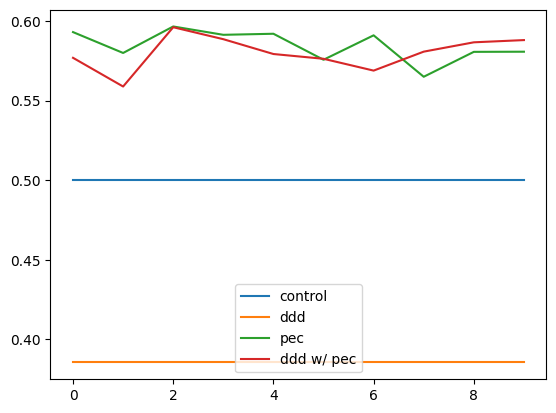

In [9]:
import cirq
from mitiq import ddd, pec
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise
from mitiq.zne.scaling import fold_global, fold_gates_at_random, insert_id_layers
import matplotlib.pyplot as plt
import warnings

a, b, c = cirq.LineQubit.range(3)
warnings.filterwarnings('ignore')

circuit = cirq.Circuit(
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.CNOT(b, c),
    cirq.S(a),
    
)

def execute(circuit, noise_level=0.005):
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit
    with depolarizing noise."""

    # add depolarizing noise
    noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))

    return (
        cirq.DensityMatrixSimulator()
        .simulate(noisy_circuit)
        .final_density_matrix[0, 0]
        .real
    )

def execute_no_noise(circuit):
    return (
        cirq.DensityMatrixSimulator()
        .simulate(circuit)
        .final_density_matrix[0, 0]
        .real
    )

@ddd.ddd_decorator(rule=ddd.rules.xyxy)
def ddd_execute(circuit):
    value = execute(circuit, noise_level=0.05)
    return(value)

def execute_pec(circuit):
    reps = represent_operations_in_circuit_with_local_depolarizing_noise(circuit, noise_level=0.05)
    pec_value = pec.execute_with_pec(circuit, execute, representations=reps)
    return pec_value

@ddd.ddd_decorator(rule=ddd.rules.xyxy)
def ddd_execute_pec(circuit):
    reps = represent_operations_in_circuit_with_local_depolarizing_noise(circuit, noise_level=0.05)
    pec_value = pec.execute_with_pec(circuit, execute, representations=reps)
    return pec_value



x = []
control_y = []
ddd_y = []
pec_y = []
ddd_pec_y = []

for i in range(0, 10):
    control = execute_no_noise(circuit)
    ddd_val = ddd_execute(circuit)
    pec_val = execute_pec(circuit)
    ddd_pec_val = ddd_execute_pec(circuit)
    ddd_pec_y.append(ddd_pec_val)
    x.append(i)
    control_y.append(control)
    ddd_y.append(ddd_val)
    pec_y.append(pec_val)




plt.plot(x, control_y, label="control")
plt.plot(x, ddd_y, label="ddd")
plt.plot(x, pec_y, label='pec')
plt.plot(x, ddd_pec_y, label='ddd w/ pec')
plt.legend()
plt.show()

Idea: What if we write QRNG for Probabilistic Error Cancelation?  Would it even be possible to stack PEC with other methods?

Code taken from https://github.com/navaro1/quantum-gacek-cirq/blob/main/randomness/bit_qubit_h.py#L3

In [ ]:
import cirq
import numpy as np

class QuantumRandomNumberGenerator:
    measurement_gate_name = 'qrng_measure'
    qubit_name_prefix = 'qrng_'

    def __init__(self, simulator=None):
        if simulator is None:
            simulator = cirq.Simulator()
        self.simulator = simulator

    def generate_binary_array(self, length: int) -> np.ndarray:
        qubits = cirq.NamedQubit.range(length, prefix=QuantumRandomNumberGenerator.qubit_name_prefix)
        h_gates = [cirq.H(qubit) for qubit in qubits]
        measurement_gate = cirq.measure(qubits, key=QuantumRandomNumberGenerator.measurement_gate_name)
        qrng_circuit = cirq.Circuit(h_gates, measurement_gate)
        result = self.simulator.simulate(qrng_circuit)
        return result.measurements[QuantumRandomNumberGenerator.measurement_gate_name]
    

qrng = QuantumRandomNumberGenerator()
print(qrng.generate_binary_array(length=3))